#Import

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

#Data Preprocessing

In [56]:
data = pd.read_csv('Biotech_clean_dataset.csv')
data

,Time,Total (W),Phase_A (W),Phase_B (W),Phase_C (W)
0,1/4/2024 15:00,821,207,467,147
1,1/4/2024 16:00,741,298,329,114
2,1/4/2024 17:00,776,363,278,135
3,1/4/2024 18:00,1260,659,419,182
4,1/4/2024 19:00,973,381,410,182
...,...,...,...,...,...
4809,7/8/2024 5:00,1040,635,259,146
4810,7/8/2024 6:00,1414,1023,251,140
4811,7/8/2024 7:00,571,225,243,103
4812,7/8/2024 8:00,784,411,280,93


In [57]:
data = data[['Time', 'Total (W)']]
data

,Time,Total (W)
0,1/4/2024 15:00,821
1,1/4/2024 16:00,741
2,1/4/2024 17:00,776
3,1/4/2024 18:00,1260
4,1/4/2024 19:00,973
...,...,...
4809,7/8/2024 5:00,1040
4810,7/8/2024 6:00,1414
4811,7/8/2024 7:00,571
4812,7/8/2024 8:00,784


In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

<ipython-input-59-bfe51e1f189c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Time'] = pd.to_datetime(data['Time'])


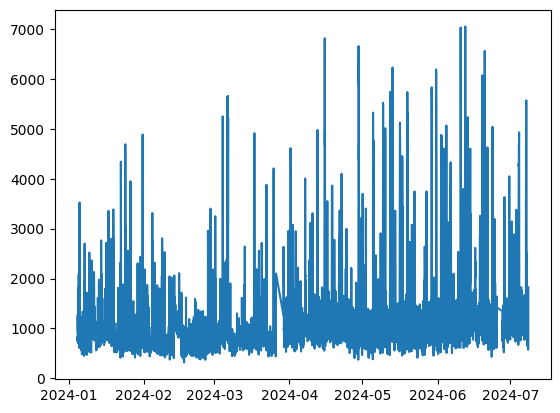

In [59]:
data['Time'] = pd.to_datetime(data['Time'])

plt.plot(data['Time'], data['Total (W)'])

In [60]:
# Prepare data for lstm
from copy import deepcopy as dc

def prepare_data(df, n_steps):
  df = dc(df)
  df.set_index('Time', inplace = True)
  for i in range(1, n_steps+1):
    df[f'Power(t-{i})'] = df['Total (W)'].shift(i)

  df.dropna(inplace = True)
  return df

lookback = 6
shifted_df = prepare_data(data, lookback)
shifted_df


,Total (W),Power(t-1),Power(t-2),Power(t-3),Power(t-4),Power(t-5),Power(t-6)
Time,,,,,,,
2024-01-04 21:00:00,1812,929.0,973.0,1260.0,776.0,741.0,821.0
2024-01-04 22:00:00,715,1812.0,929.0,973.0,1260.0,776.0,741.0
2024-01-04 23:00:00,959,715.0,1812.0,929.0,973.0,1260.0,776.0
2024-01-05 00:00:00,834,959.0,715.0,1812.0,929.0,973.0,1260.0
2024-01-05 01:00:00,694,834.0,959.0,715.0,1812.0,929.0,973.0
...,...,...,...,...,...,...,...
2024-07-08 05:00:00,1040,645.0,1288.0,1200.0,827.0,934.0,1358.0
2024-07-08 06:00:00,1414,1040.0,645.0,1288.0,1200.0,827.0,934.0
2024-07-08 07:00:00,571,1414.0,1040.0,645.0,1288.0,1200.0,827.0


In [61]:
shifted_df_np = shifted_df.to_numpy()
shifted_df_np

array([[1812.,  929.,  973., ...,  776.,  741.,  821.],
       [ 715., 1812.,  929., ..., 1260.,  776.,  741.],
       [ 959.,  715., 1812., ...,  973., 1260.,  776.],
       ...,
       [ 571., 1414., 1040., ..., 1288., 1200.,  827.],
       [ 784.,  571., 1414., ...,  645., 1288., 1200.],
       [1824.,  784.,  571., ..., 1040.,  645., 1288.]])

In [62]:
shifted_df_np.shape

(4808, 7)

In [63]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_np = scaler.fit_transform(shifted_df_np)
shifted_df_np

array([[-0.55595132, -0.8180469 , -0.80498664, ..., -0.86346097,
        -0.87384981, -0.85010389],
       [-0.88156723, -0.55595132, -0.8180469 , ..., -0.71979816,
        -0.86346097, -0.87384981],
       [-0.80914218, -0.88156723, -0.55595132, ..., -0.80498664,
        -0.71979816, -0.86346097],
       ...,
       [-0.92430988, -0.67408727, -0.78509944, ..., -0.71148709,
        -0.7376076 , -0.84832294],
       [-0.86108638, -0.92430988, -0.67408727, ..., -0.90234491,
        -0.71148709, -0.7376076 ],
       [-0.55238943, -0.86108638, -0.92430988, ..., -0.78509944,
        -0.90234491, -0.71148709]])

In [64]:
X = shifted_df_np[:, 1:]
y = shifted_df_np[:, 0]

X.shape, y.shape

((4808, 6), (4808,))

In [65]:
X = dc(np.flip(X, axis=1))
X

array([[-0.85010389, -0.87384981, -0.86346097, -0.71979816, -0.80498664,
        -0.8180469 ],
       [-0.87384981, -0.86346097, -0.71979816, -0.80498664, -0.8180469 ,
        -0.55595132],
       [-0.86346097, -0.71979816, -0.80498664, -0.8180469 , -0.55595132,
        -0.88156723],
       ...,
       [-0.84832294, -0.7376076 , -0.71148709, -0.90234491, -0.78509944,
        -0.67408727],
       [-0.7376076 , -0.71148709, -0.90234491, -0.78509944, -0.67408727,
        -0.92430988],
       [-0.71148709, -0.90234491, -0.78509944, -0.67408727, -0.92430988,
        -0.86108638]])

In [66]:
split_index = int(len(X)*0.8)
split_index

3846

In [67]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3846, 6), (962, 6), (3846,), (962,))

In [68]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3846, 6, 1), (962, 6, 1), (3846, 1), (962, 1))

In [69]:
type(X_train)

numpy.ndarray

In [70]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3846, 6, 1]),
 torch.Size([962, 6, 1]),
 torch.Size([3846, 1]),
 torch.Size([962, 1]))

In [71]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)


In [72]:
train_dataset

In [73]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

In [74]:
# print the shape of one batch
for _, (X, y) in enumerate(train_loader):
  X_batch, y_batch = X.to(device), y.to(device)
  print(X_batch.shape, y_batch.shape)
  break

torch.Size([32, 6, 1]) torch.Size([32, 1])


#Create LSTM model

In [75]:
# create the model
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super(LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

model = LSTM(1, 4, 1)
model.to(device)
model


LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

#Model Training

In [76]:
def train_one_epoch():
  model.train(True)
  print(f"Epoch: {epoch+1}")
  running_loss = 0.0

  for batch_index, (X, y) in enumerate(train_loader):
    X_batch, y_batch = X.to(device), y.to(device)
    output = model(X_batch)
    loss = loss_function(output, y_batch)
    running_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (batch_index+1) % 20 == 0:
      avg_loss_across_batches = running_loss / 20
      print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,avg_loss_across_batches))
      running_loss = 0.0

    print()


In [77]:
def validate_one_epoch():
  model.train(False)
  running_loss = 0.0

  for batch_index, (X, y) in enumerate(test_loader):
    x_batch, y_batch = X.to(device), y.to(device)
    with torch.no_grad():
      output = model(x_batch)
      loss = loss_function(output, y_batch)
      running_loss += loss.item()

  avg_loss_across_batches = running_loss / len(test_loader)
  print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
  print('***************************************************')
  print()

In [78]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  train_one_epoch()
  validate_one_epoch()

Epoch: 1



















Batch 20, Loss: 0.743




















Batch 40, Loss: 0.598




















Batch 60, Loss: 0.475




















Batch 80, Loss: 0.340




















Batch 100, Loss: 0.238




















Batch 120, Loss: 0.156


Val Loss: 0.101
***************************************************

Epoch: 2



















Batch 20, Loss: 0.107




















Batch 40, Loss: 0.071




















Batch 60, Loss: 0.069




















Batch 80, Loss: 0.063




















Batch 100, Loss: 0.066




















Batch 120, Loss: 0.066


Val Loss: 0.068
***************************************************

Epoch: 3



















Batch 20, Loss: 0.049




















Batch 40, Loss: 0.062




















Batch 60, Loss: 0.051




















Batch 80, Loss: 0.073




















Batch 100, Loss: 0.044




















Batch 120, Loss: 0.054


Val Loss: 0.068
***************************************************

E

# Model Evaluation on Training Data

In [95]:
# model evaluation on training set
with torch.no_grad():
  train_predicted = model(X_train.to(device)).to('cpu').numpy()
  train_actual = y_train.to(device).to('cpu').numpy()
  # print("predicted: ", predicted, "\nactual: ", actual)
  train_results = pd.DataFrame(data={'Train Predictions': train_predicted.ravel(), 'Actuals': train_actual.ravel()})
train_results

,Train Predictions,Actuals
0,-0.788391,-0.555951
1,-0.733275,-0.881567
2,-0.769144,-0.809142
3,-0.766119,-0.846245
4,-0.780080,-0.887801
...,...,...
3841,-0.653549,-0.704957
3842,-0.671166,-0.879786
3843,-0.729712,-0.877412
3844,-0.761249,-0.901454


In [97]:
train_MAPE = abs(train_results['Train Predictions']-train_results['Actuals'])*100.0/abs(train_results['Actuals'])
train_MAPE = train_MAPE.mean()
train_MAPE

38.68701

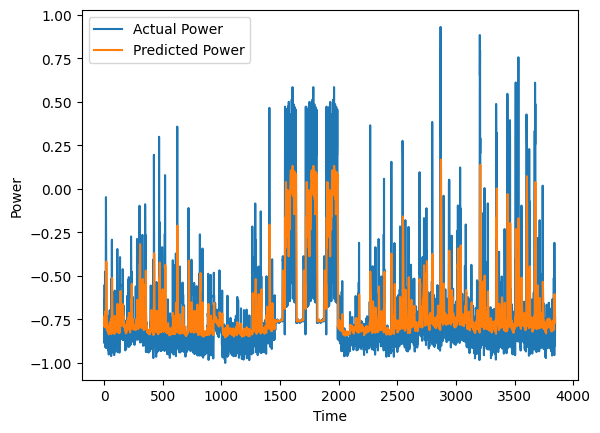

In [98]:
# Plot on Training Data
plt.plot(y_train, label='Actual Power')
plt.plot(train_predicted, label='Predicted Power')
plt.xlabel('Time')
plt.ylabel('Power')
plt.legend()
plt.show()

In [99]:
# Transform the train_predictions to actual values
train_predictions = train_predicted.flatten()
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)
train_predictions = dc(dummies[:, 0])

In [108]:
# Transform y_train to actual values
dummies = np.zeros((y_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)
transformed_y_train = dc(dummies[:, 0])

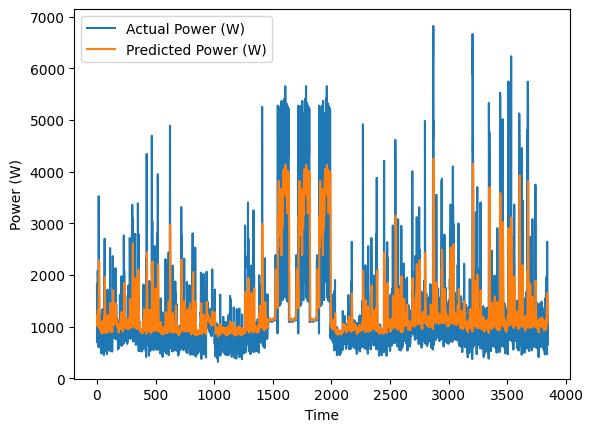

In [109]:
# Plot on the transformed training data
plt.plot(transformed_y_train, label='Actual Power (W)')
plt.plot(train_predictions, label='Predicted Power (W)')
plt.xlabel('Time')
plt.ylabel('Power (W)')
plt.legend()
plt.show()

In [127]:
train_diff = train_predictions - transformed_y_train
train_diff_sq = np.square(train_diff)
train_RMSE = np.sqrt(train_diff_sq.mean())
train_RMSE

714.562401274682

# Model Evaluation on Test Data

In [93]:
with torch.no_grad():
  test_predicted = model(X_test.to(device)).to('cpu').numpy()
  test_actual = y_test.to(device).to('cpu').numpy()
  # print("predicted: ", predicted, "\nactual: ", actual)
  test_results = pd.DataFrame(data={'Test Predictions': test_predicted.ravel(), 'Actuals': test_actual.ravel()})
test_results

,Test Predictions,Actuals
0,-0.776144,-0.726328
1,-0.770500,-0.872959
2,-0.796014,-0.899377
3,-0.805242,-0.912734
4,-0.811996,-0.698724
...,...,...
957,-0.783533,-0.785099
958,-0.779549,-0.674087
959,-0.753558,-0.924310
960,-0.787050,-0.861086


In [94]:
test_MAPE = abs(test_results['Test Predictions']-test_results['Actuals'])*100.0/abs(test_results['Actuals'])
test_MAPE = test_MAPE.mean()
test_MAPE

80.168175

In [110]:
# Transform the test_predictions to actual values
test_predictions = test_predicted.flatten()
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)
test_predictions = dc(dummies[:, 0])

In [111]:
# Transform y_train to actual values
dummies = np.zeros((y_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)
transformed_y_test = dc(dummies[:, 0])

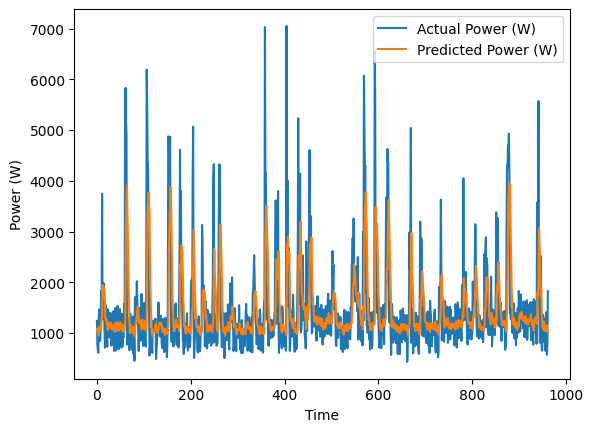

In [112]:
# Plot on the transformed test data
plt.plot(transformed_y_test, label='Actual Power (W)')
plt.plot(test_predictions, label='Predicted Power (W)')
plt.xlabel('Time')
plt.ylabel('Power (W)')
plt.legend()
plt.show()

In [126]:
test_diff = test_predictions - transformed_y_test
test_diff_sq = np.square(test_diff)
test_RMSE = np.sqrt(test_diff_sq.mean())
test_RMSE

889.4238162898052